In [1]:
import tarfile

# extracting data from the compressed file
cifar10 = tarfile.open("datasets/cifar-10.tar.gz")
cifar10.extractall("datasets")
cifar10.close()

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import random
from tensorflow.keras.layers import Input, Conv2D, ZeroPadding2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Activation, Dense, Add, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from matplotlib.pyplot import imshow
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

%matplotlib inline
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

dataset_dir = "datasets/cifar-10-batches-py"

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [3]:
# function to load the dataset
def load_dataset():
    
    # function to load "file" to "dict"
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding = 'bytes')
        return dict
    
    batches_meta_dict = unpickle(dataset_dir + "/batches.meta")
    label_names = batches_meta_dict[b'label_names']
    label_names = np.array(label_names)
    
    #data batches
    train_data_batches = None
    train_labels_batches = []
    
    #training data
    train_data = None
    train_labels = []
    
    #validation data
    valid_data = None
    valid_labels = []
    
    # iterating through the train data batches and loading them to "train_data_batches"
    for i in range(1, 6):
        train_data_dict = unpickle(dataset_dir + "/data_batch_{}".format(i))
        if i == 1:
            train_data_batches = train_data_dict[b'data']
        else:
            train_data_batches = np.vstack((train_data_batches, train_data_dict[b'data']))
        train_labels_batches += train_data_dict[b'labels']
        
    train_data_batches = train_data_batches.reshape((len(train_data_batches), 3, 32, 32))
    train_data_batches = np.rollaxis(train_data_batches, 1, 4)
    train_labels_batches = np.array(train_labels_batches)
    
    # splitting "train_data_batches" to "train_data" and "valid_data"
    train_data = train_data_batches[0:45000]
    train_labels = train_labels_batches[0:45000]
    valid_data = train_data_batches[45000:50001]
    valid_labels = train_labels_batches[45000:50001]
        
    test_data_dict = unpickle(dataset_dir + "/test_batch")
    test_data = test_data_dict[b'data']
    test_labels = test_data_dict[b'labels']
    
    test_data = test_data.reshape((len(test_data), 3, 32, 32))
    test_data = np.rollaxis(test_data, 1, 4)
    test_labels = np.array(test_labels)
    
    return train_data, train_labels, valid_data, valid_labels, test_data, test_labels, label_names

In [4]:
# function for one hot encoding
def convert_to_one_hot(Y, C):
    
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [5]:
# function to add 4 pixels on each side and randomly cropping a 32 x 32 sample
def rand_crop(img):
    
    img = tf.reshape(img, shape = [1, 32, 32, 3]) # reshaping image to 4 dimensions
    img = ZeroPadding2D((4, 4))(img) # adding 4 pixels on each side
    img = tf.reshape(img, shape = [40, 40, 3]) # reshaping back into 3 dimensions
    
    # randomly selecting the start point
    start_h = random.randint(0, 7)
    start_w = random.randint(0, 7)
    
    img = img[start_h:start_h+32, start_w:start_w+32, :] # cropping the image
    
    return img

In [6]:
X_train_orig, Y_train_orig, X_valid_orig, Y_valid_orig, X_test_orig, Y_test_orig, labels = load_dataset() # loading the dataset

In [7]:
print("X_train_orig shape: ", X_train_orig.shape)
print("Y_train_orig shape: ", Y_train_orig.shape)
print("X_valid_orig shape: ", X_valid_orig.shape)
print("Y_valid_orig shape: ", Y_valid_orig.shape)
print("X_test_orig shape: ", X_test_orig.shape)
print("Y_test_orig shape: ", Y_test_orig.shape)

X_train_orig shape:  (45000, 32, 32, 3)
Y_train_orig shape:  (45000,)
X_valid_orig shape:  (5000, 32, 32, 3)
Y_valid_orig shape:  (5000,)
X_test_orig shape:  (10000, 32, 32, 3)
Y_test_orig shape:  (10000,)


In [8]:
# data normalization
X_train = X_train_orig.astype("float32")
X_valid = X_valid_orig.astype("float32")
X_test = X_test_orig.astype("float32")
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train - mean) / std
X_valid = (X_valid - mean) / std
X_test = (X_test - mean) / std

In [9]:
# one hot encoding the Y's
Y_train = convert_to_one_hot(Y_train_orig, 10).T
Y_valid = convert_to_one_hot(Y_valid_orig, 10).T
Y_test = convert_to_one_hot(Y_test_orig, 10).T

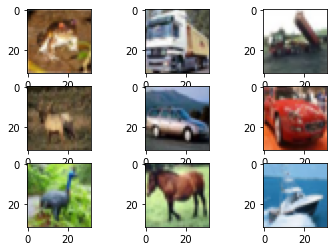

In [10]:
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train_orig[i])
plt.show()

In [11]:
# data augmentation
datagen = ImageDataGenerator(
horizontal_flip = True,
preprocessing_function = rand_crop)

datagen.fit(X_train)

In [12]:
print("X_train shape: ",X_train.shape)
print("Y_train shape: ",Y_train.shape)
print("X_valid shape: ", X_valid.shape)
print("Y_valid shape: ", Y_valid.shape)
print("X_test shape: ",X_test.shape)
print("Y_test shape: ",Y_test.shape)

X_train shape:  (45000, 32, 32, 3)
Y_train shape:  (45000, 10)
X_valid shape:  (5000, 32, 32, 3)
Y_valid shape:  (5000, 10)
X_test shape:  (10000, 32, 32, 3)
Y_test shape:  (10000, 10)


In [13]:
def identity_block(X, f, filters, stage, block):
    
    # name basis
    conv_name_base = "res"+str(stage)+block+"_branch"
    bn_name_base = "bn"+str(stage)+block+"_branch"
    
    # retreiving filters
    F1, F2, F3 = filters
    
    # saving the input value
    X_shortcut = X
    
    # first component of main path
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = "valid", name = conv_name_base + "2a", kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + "2a")(X)
    X = Activation("relu")(X)
    
    # second component of main path
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = "same", name = conv_name_base + "2b", kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + "2b")(X)
    X = Activation("relu")(X)
    
    # third component of main path
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = "valid", name = conv_name_base + "2c", kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + "2c")(X)
    
    # final step : addition of input value to the main path
    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)
    
    return X

In [14]:
def convolutional_block(X, f, filters, stage, block, s=2):
    
    # name basis
    conv_name_base = "res"+str(stage)+block+"_branch"
    bn_name_base = "bn"+str(stage)+block+"_branch"
    
    # retrieving filters
    F1, F2, F3 = filters
    
    # saving the input value
    X_shortcut = X
    
    # first component of main path
    X = Conv2D(F1, (1,1), strides = (s,s), padding="valid", name = conv_name_base + "2a", kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + "2a")(X)
    X = Activation("relu")(X)
    
    # second component of main path
    X = Conv2D(F2, (f,f), strides = (1,1), padding="same", name = conv_name_base + "2b", kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + "2b")(X)
    X = Activation("relu")(X)
    
    # third component of main path
    X = Conv2D(F3, (1,1), strides = (1,1), padding="valid", name = conv_name_base + "2c", kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + "2c")(X)
    
    # shortcut path : matching the dimensions of shortcut path to that of main path
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding="valid", name = conv_name_base + "1", kernel_initializer = glorot_uniform())(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + "1")(X_shortcut)
    
    # final step : addition of main path and shortcut path
    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)
    
    return X

In [15]:
def ResNet(input_shape = (32, 32, 3), classes = 10, n = 1):
    
    X_input = Input(input_shape)
        
    X = X_input
    
    # first layer
    # output size : 32 x 32 x 16 
    X = Conv2D(16, (3,3), strides = (1,1), padding = "same", name = "conv1", kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = "bn_conv1")(X)
    X = Activation("relu")(X)
    
    # first set of 2n layers
    # output size : 32 x 32 x 64
    X = convolutional_block(X, f = 3, filters = [16, 16, 64], stage = 2, block = "a", s = 1)
    for i in range(2 * n - 1):
        X = identity_block(X, f = 3, filters = [16, 16, 64], stage = 2, block = chr(97+i+1))
    
    # second set of 2n layers
    # output size : 16 x 16 x 128
    X = convolutional_block(X, f = 3, filters = [32, 32, 128], stage = 3, block = "a", s = 2)
    for i in range(2 * n - 1):
        X = identity_block(X, f = 3, filters = [32, 32, 128], stage = 3, block = chr(97+i+1))
    
    # third set of 2n layers
    # output size : 8 x 8 x 256
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 4, block = "a", s = 2)
    for i in range(2 * n - 1):
        X = identity_block(X, f = 3, filters = [64, 64, 256], stage = 4, block = chr(97+i+1))
    
    # output size : 1 x 1 x 256
    X = AveragePooling2D((8,8), name = "avg_pool")(X)
    
    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation = "softmax", kernel_regularizer = l2(0.001), bias_regularizer = l2(0.001), name = "fc"+str(classes), kernel_initializer = glorot_uniform())(X)
    
    model = Model(inputs = X_input, outputs = X, name = "ResNet")
    
    return model

In [16]:
model = ResNet(input_shape = (32, 32, 3), classes = 10, n = 3) # number of layers = 6n + 2

In [17]:
sgd = SGD(learning_rate = 0.1, momentum = 0.9, name = "SGD") # SGD optimizer with 0.1 initial learning rate of 0.1 and momentum = 0.9
model.compile(optimizer = sgd, loss = "categorical_crossentropy", metrics = ["accuracy"]) # compiling the model with categorical crossentropy loss and setting the metric as accuracy

In [18]:
early = EarlyStopping(monitor = "val_accuracy", min_delta = 0.0001, patience = 25, mode = "auto") # the training is stopped when the validation accuracy doesn't increase by 0.01 percent for 25 epochs
checkpoint = ModelCheckpoint("tmp/checkpoint", monitor = "val_accuracy", save_best_only = True, save_weights_only = False, mode = "auto") # checkpoint for the model with best validation accuracy
rlrop = ReduceLROnPlateau(monitor = "val_accuracy", factor = 0.1, min_delta = 0.0001, patience = 10, mode = "auto") # the learning rate is divided by 10 when the validation accuracy doesn't increase by 0.01 percent for 10 epochs

In [19]:
model.summary() # summary of the model

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 16)   64          conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           bn_conv1[0][0]                   
_____________________________________________________________________________________________

In [20]:
hist = model.fit(datagen.flow(X_train, Y_train), epochs = 200, validation_data = (X_valid, Y_valid), callbacks = [early, checkpoint, rlrop]) # training the model for 200 epochs

Epoch 1/200
1407/1407 [==============================] - ETA: 0s - loss: 2.0360 - accuracy: 0.2615 ETA: 1sWARNING:tensorflow:From C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: tmp\checkpoint\assets
1407/1407 [==============================] - 164s 116ms/step - loss: 2.0360 - accuracy: 0.2615 - val_loss: 1.8027 - val_accuracy: 0.3570
Epoch 2/200
1407/1407 [==============================] - 163s 116ms/step - loss: 1.6532 - accuracy: 0.3992 - val_loss: 1.6819 - val_accuracy: 0.4214
Epoch 3/200
1407/1407 [==============================] 

In [21]:
model1 = load_model("tmp/checkpoint") # loading the model with the best validation accuracy

In [22]:
# evaluation of the model
predsTrain = model1.evaluate(X_train, Y_train)
predsTest = model1.evaluate(X_test, Y_test)
predsValid = model1.evaluate(X_valid, Y_valid)
print("Training Accuracy: ", predsTrain[1])
print("Validation Accuracy: ", predsValid[1])
print("Test Accuracy: ", predsTest[1])

157/157 [==============================] - 2s 16ms/step - loss: 0.3071 - accuracy: 0.9196
Training Accuracy:  0.9879999756813049
Validation Accuracy:  0.9196000099182129
Test Accuracy:  0.9085000157356262


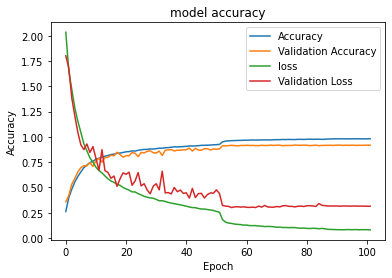

In [23]:
# variation of accuracies and losses with epochs
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

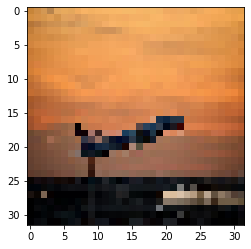

prediction:  b'airplane'


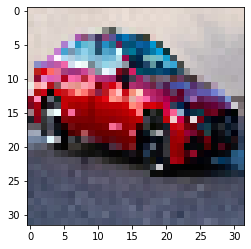

prediction:  b'automobile'


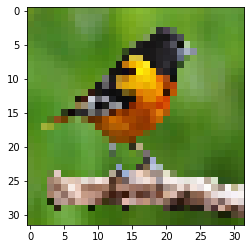

prediction:  b'bird'


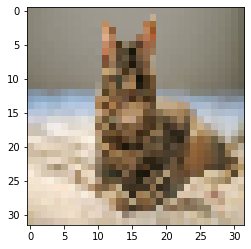

prediction:  b'cat'


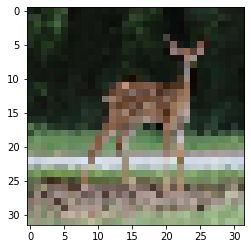

prediction:  b'deer'


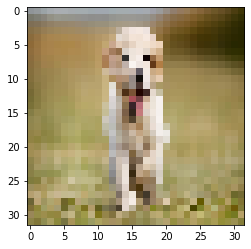

prediction:  b'dog'


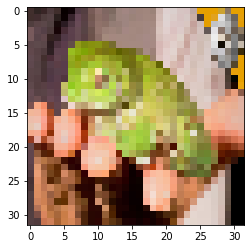

prediction:  b'frog'


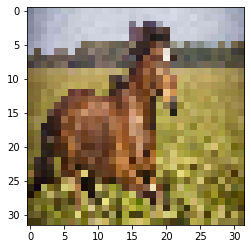

prediction:  b'horse'


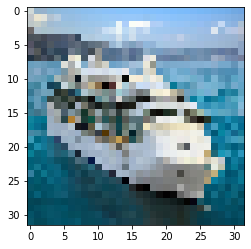

prediction:  b'airplane'


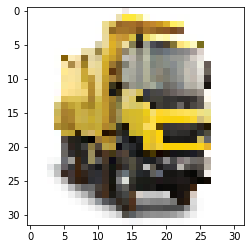

prediction:  b'truck'


In [24]:
# function to make predictions using the model
def predict(images_path):
  for i in range(len(images_path)):
    img = image.load_img(images_path[i], target_size = (32, 32)) # loading the image and resizing to 32 x 32
    x = image.img_to_array(img) # converting image to array
    x = np.expand_dims(x, axis = 0) # expanding the dimensions
    imshow(np.squeeze(x.astype(int))) # printing the images
    plt.show()
    x = (x - mean) / std # normalization
    prediction = model1.predict(x) # getting the prediction vector
    prediction = np.squeeze(prediction)
    max = np.max(prediction)
    print("prediction: ",labels[prediction.tolist().index(max)]) # printing the label with the highest probability 

images = ["plane.jpg","car.jpg", "bird.jpg", "cat.jpg", "deer.jpg", "dog.jpeg", "frog.jpg", "horse.jpg", "ship.jpg", "truck.jpg"]
predict(images)

In [25]:
# printing the confusion matrix and the classification report
print("Labels\n")
print(labels)
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis = 1)
y_test = np.argmax(Y_test, axis = 1)
print("\nConfusion Matrix\n")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report\n")
print(classification_report(y_test, y_pred, target_names=labels))

Labels

[b'airplane' b'automobile' b'bird' b'cat' b'deer' b'dog' b'frog' b'horse'
 b'ship' b'truck']

Confusion Matrix

[[926   6  18   8   9   0   1   2  21   9]
 [  5 964   0   0   0   0   1   1   7  22]
 [ 24   0 881  30  26  12  18   6   2   1]
 [ 11   2  30 810  27  78  23   9   6   4]
 [  5   0  22  14 927  11   8   9   3   1]
 [  6   0  14 102  26 830   8  11   1   2]
 [  4   0  16  25   8   6 935   2   2   2]
 [  5   1  11  19  21  17   1 923   0   2]
 [ 30  10   3   6   0   0   1   0 946   4]
 [  7  29   3   4   0   0   1   0  10 946]]

Classification Report

              precision    recall  f1-score   support

 b'airplane'       0.91      0.93      0.92      1000
b'automobile'       0.95      0.96      0.96      1000
     b'bird'       0.88      0.88      0.88      1000
      b'cat'       0.80      0.81      0.80      1000
     b'deer'       0.89      0.93      0.91      1000
      b'dog'       0.87      0.83      0.85      1000
     b'frog'       0.94      0.94      0.94  